# Plex Pricing: XGBoost Model

This notebook builds an XGBoost regression model for plex pricing prediction with hyperparameter tuning.

In [1]:
# Imports & setup
import os, sys, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-deep')
sns.set_palette('husl')

# Setup paths and configuration
sys.path.append('../')

# Import configuration and data preparation
from utils.config import get_config, print_config
from utils.functions import prepare_plex_data, evaluate, find_discounted_properties, analyze_market_opportunities
from sklearn.model_selection import HalvingRandomSearchCV

# Load configuration from .env file
config = get_config()
DATA_PATH = config['data_path']
SEED = config['random_seed']
MAX_PRICE = 1_750_000

print_config()

Configuration:
----------------------------------------
data_path                : G:\My Drive\Coding Projects\data\centris_comprehensive_plex_data.csv
target_year              : 2025
assessment_growth_rate   : 0.057
random_seed              : 42
platform                 : Windows
----------------------------------------


In [2]:
# Load & prepare data (no global standardization -> we'll scale in model pipelines)
raw = pd.read_csv(DATA_PATH)

prepared, scaler_unused = prepare_plex_data(
    df=raw, 
    target_year=config['target_year'], 
    assessment_growth_rate=config['assessment_growth_rate'], 
    standardize=False, 
    drop_original_geo=True
)

# prepared = prepared[prepared['distance_from_mtl'] < 50]

# Clean NaNs / Infs for modeling
prepared = prepared.replace([np.inf, -np.inf], np.nan).dropna()
print('Prepared shape:', prepared.shape)
print('Columns:', list(prepared.columns))

# Remove properties with prices above MAX_PRICE
prepared = prepared[prepared['price'] <= MAX_PRICE]

target_col = 'price'
feature_cols = [c for c in prepared.columns if c != target_col]
X = prepared[feature_cols].copy()
y = prepared[target_col].astype(float).copy()

# Train/Validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)
X_train.shape, X_test.shape

Adjusting assessment values to 2025 using 5.7% annual growth...
Standardizing building style labels...
Creating geographic features...
Encoding building styles...
Creating financial and property features...
New features created: ['revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached']
Prepared shape: (4502, 16)
Columns: ['price', 'year_built', 'walkscore', 'lot_area_sqft', 'units_count', 'gross_potential_income', 'assessment_total_adj', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached', 'revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age']


((3069, 15), (1316, 15))

## XGBoost with Hyperparameter Tuning
Using XGBoost with randomized search to find optimal hyperparameters.

In [3]:
# XGBoost with comprehensive hyperparameter tuning
base_xgb = XGBRegressor(
    objective='reg:squarederror', 
    random_state=SEED, 
    n_jobs=-1,
    eval_metric='rmse'
)

# Extended parameter grid for fine-tuning
param_dist = {
    'n_estimators': [300, 500, 800, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1.0]
}

# Randomized search with more iterations for better tuning
xgb_search = HalvingRandomSearchCV(
    base_xgb,
    param_distributions=param_dist,
    factor=3,  # default factor for resource allocation
    cv=5,
    random_state=SEED,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

print("Starting XGBoost hyperparameter search...")
t0 = time.time()
xgb_search.fit(X_train, y_train)
t_xgb = time.time() - t0

xgb_model = xgb_search.best_estimator_
print(f"XGBoost fit time: {t_xgb:.2f}s")
print(f"Best XGBoost score (CV): {-xgb_search.best_score_:.4f}")
print("Best parameters:", xgb_search.best_params_)

Starting XGBoost hyperparameter search...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 10
max_resources_: 3069
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 306
n_resources: 10
Fitting 5 folds for each of 306 candidates, totalling 1530 fits
----------
iter: 1
n_candidates: 102
n_resources: 30
Fitting 5 folds for each of 102 candidates, totalling 510 fits
----------
iter: 1
n_candidates: 102
n_resources: 30
Fitting 5 folds for each of 102 candidates, totalling 510 fits
----------
iter: 2
n_candidates: 34
n_resources: 90
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 34
n_resources: 90
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 3
n_candidates: 12
n_resources: 270
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 12
n_resources: 270
Fitting 5 folds for each of 12 candidates, totalling 60 fits
-------

In [4]:
# Evaluate XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
metrics_xgb = evaluate(y_test, y_pred_xgb)

print("XGBoost Test Performance:")
for metric, value in metrics_xgb.items():
    print(f"  {metric}: {value:.4f}")

XGBoost Test Performance:
  R2: 0.9949
  RMSE: 23727.3781
  MAE: 14250.1097


## Feature Importances

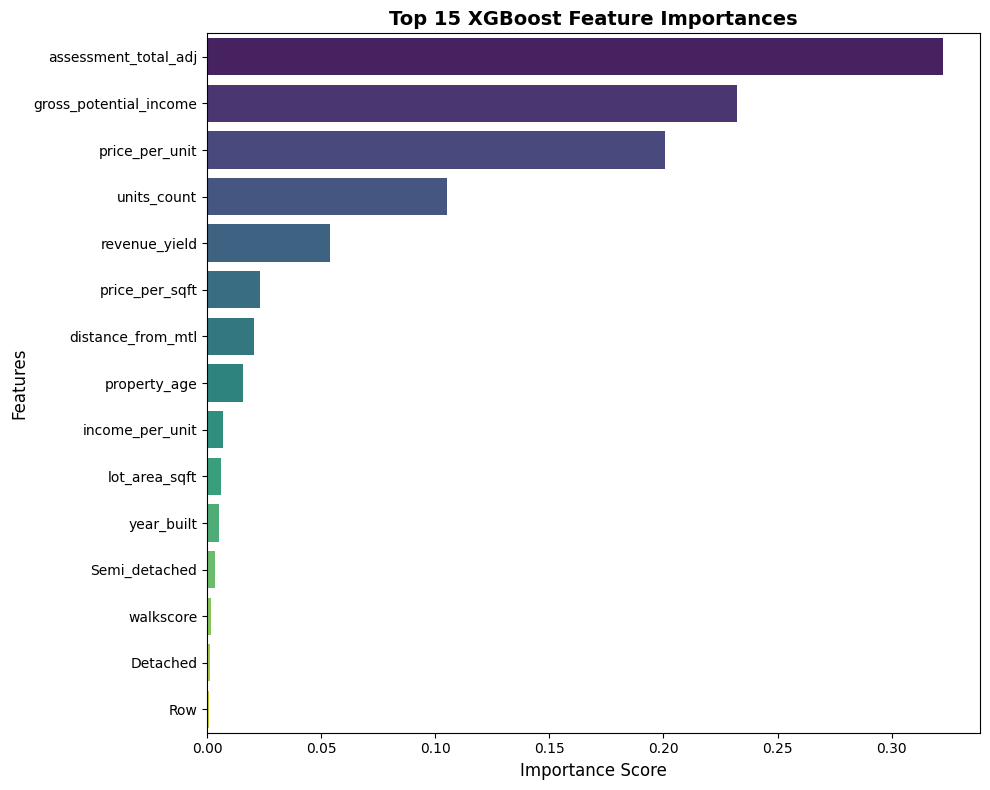

Top 10 Most Important Features:
 1. assessment_total_adj 0.3226
 2. gross_potential_income 0.2322
 3. price_per_unit       0.2007
 4. units_count          0.1050
 5. revenue_yield        0.0540
 6. price_per_sqft       0.0232
 7. distance_from_mtl    0.0205
 8. property_age         0.0159
 9. income_per_unit      0.0071
10. lot_area_sqft        0.0062


In [5]:
# XGBoost Feature Importances
importances = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
top_features = importances.head(15)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 15 XGBoost Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importances.head(10).items(), 1):
    print(f"{i:2d}. {feature:<20} {importance:.4f}")

## Model Performance Visualization

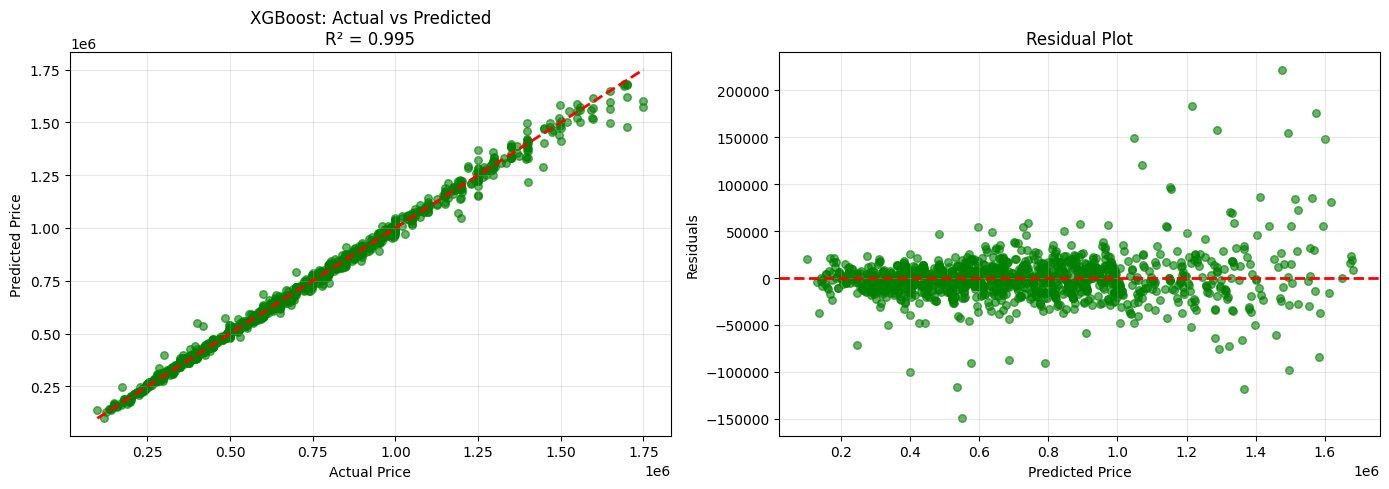

In [6]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Actual vs Predicted
axes[0].scatter(y_test, y_pred_xgb, alpha=0.6, color='green', s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'XGBoost: Actual vs Predicted\nR² = {metrics_xgb["R2"]:.3f}')
axes[0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - y_pred_xgb
axes[1].scatter(y_pred_xgb, residuals, alpha=0.6, color='green', s=30)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Find properties priced at least $50k below predicted value
discounted_properties = find_discounted_properties(
    model=xgb_model,
    data=prepared,
    price_col='price',
    feature_cols=feature_cols,
    discount_threshold=-50000,  # $50k+ discount
    top_n=20
)

print(f"Found {len(discounted_properties)} properties with at least $50k discount")
print(f"\nAverage discount: ${abs(discounted_properties['discount_amount'].mean()):,.0f}")
print(f"Median discount: ${abs(discounted_properties['discount_amount'].median()):,.0f}")
print(f"Max discount: ${abs(discounted_properties['discount_amount'].min()):,.0f}")

discounted_properties[['price', 'predicted_price', 'discount_amount', 'discount_percent']].head(10)

Found 18 properties with at least $50k discount

Average discount: $83,782
Median discount: $80,123
Max discount: $149,516


,price,predicted_price,discount_amount,discount_percent
mls,,,,
24479343,399888.0,5.494036e+05,-149515.62500,-27.214168
10796467,1250000.0,1.367787e+06,-117786.62500,-8.611477
18673493,419900.0,5.361139e+05,-116213.87500,-21.677088
27913315,299900.0,4.002621e+05,-100362.09375,-25.074094
23070387,1399000.0,1.496818e+06,-97818.37500,-6.535086
16920993,484000.0,5.750493e+05,-91049.31250,-15.833305
21958165,698900.0,7.893985e+05,-90498.50000,-11.464235
28949046,599000.0,6.867761e+05,-87776.06250,-12.780886
28566484,1499000.0,1.583295e+06,-84294.62500,-5.324001


## Find Discounted Properties

Identify properties priced significantly below the model's prediction - potential market opportunities.

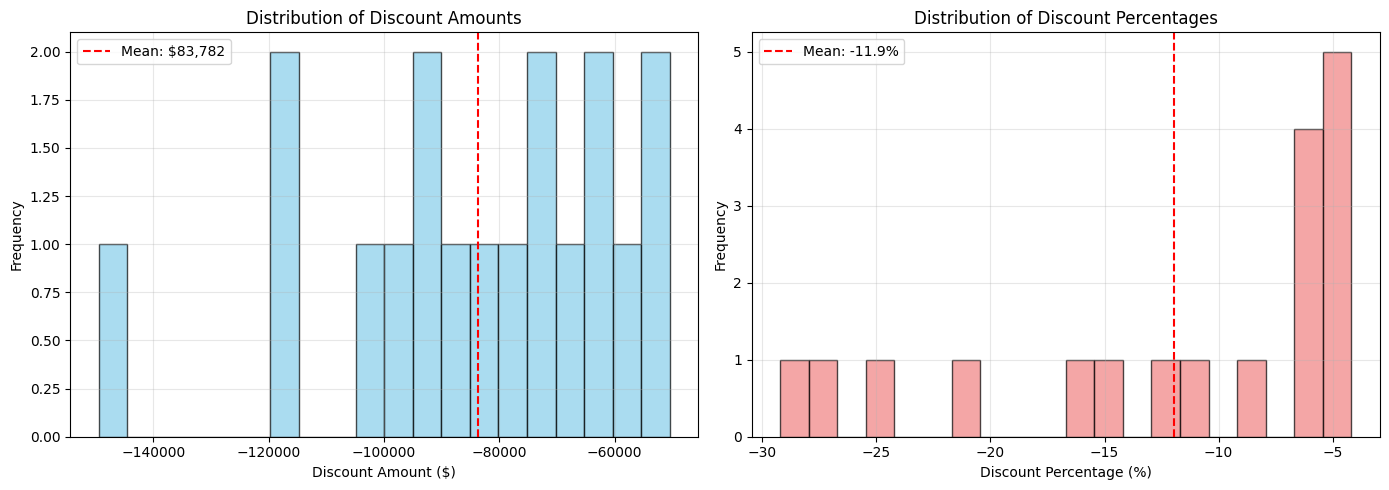


Discount Statistics:
  Average discount: $83,782 (-11.9%)
  Median discount:  $80,123 (-7.6%)
  Largest discount: $149,516 (-29.2%)


In [8]:
# Visualize discount distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Discount amount distribution
axes[0].hist(discounted_properties['discount_amount'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Discount Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Discount Amounts')
axes[0].axvline(discounted_properties['discount_amount'].mean(), color='red', linestyle='--', 
                label=f'Mean: ${abs(discounted_properties["discount_amount"].mean()):,.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Discount percentage distribution
axes[1].hist(discounted_properties['discount_percent'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Discount Percentage (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Discount Percentages')
axes[1].axvline(discounted_properties['discount_percent'].mean(), color='red', linestyle='--',
                label=f'Mean: {discounted_properties["discount_percent"].mean():.1f}%')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nDiscount Statistics:")
print(f"  Average discount: ${abs(discounted_properties['discount_amount'].mean()):,.0f} ({discounted_properties['discount_percent'].mean():.1f}%)")
print(f"  Median discount:  ${abs(discounted_properties['discount_amount'].median()):,.0f} ({discounted_properties['discount_percent'].median():.1f}%)")
print(f"  Largest discount: ${abs(discounted_properties['discount_amount'].min()):,.0f} ({discounted_properties['discount_percent'].min():.1f}%)")

In [9]:
from importlib import reload
import utils.functions
reload(utils.functions)
from utils.functions import analyze_market_opportunities

# Display detailed analysis of top opportunities
analyze_market_opportunities(discounted_properties, top_n=10, raw=raw)


TOP 10 MARKET OPPORTUNITIES - Properties Below Predicted Value

1. MLS: 24479343
   Listing URL: https://www.centris.ca/fr/duplex~a-vendre~lachute/24479343?uc=1
   Address: 587 - 587A, Rue Principale, Lachute
   Actual Price:    $ 399,888     
   Predicted Price: $ 549,404     
   Discount:        $ 149,516      (-27.2%)
   Units: 1 | Built: 1955 | Lot: 3,189 sqft

2. MLS: 10796467
   Listing URL: https://www.centris.ca/fr/triplex~a-vendre~montreal-le-plateau-mont-royal/10796467?uc=1
   Address: 4000 - 4004, Avenue De Lorimier, Montréal (Le Plateau-Mont-Royal)
   Actual Price:    $ 1,250,000   
   Predicted Price: $ 1,367,787   
   Discount:        $ 117,787      (-8.6%)
   Units: 2 | Built: 1910 | Lot: 2,077 sqft

3. MLS: 18673493
   Listing URL: https://www.centris.ca/fr/duplex~a-vendre~saint-cuthbert/18673493?uc=1
   Address: 1960Z, Rue Principale, Saint-Cuthbert
   Actual Price:    $ 419,900     
   Predicted Price: $ 536,114     
   Discount:        $ 116,214      (-21.7%)
   Uni